In [606]:

%matplotlib inline

#version 1

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
display(HTML("<style> .container { width:100%; }</style>")) #jupyter full screen width
display(HTML("<style> .CodeMirror pre { font-size: 12pt; line-height: 110%;} </style>")) #jupyter font
figSize = (18,12) #figure size
lW = 1 #line width for graphs


## Constants setup

In [607]:

pLen      = 1    # pendulum length, meters
pLenError = 0.02  # pendulum length error. TRY VARIOUS VALUES
g = 9.81   #gravitational acceleration
dT = 0.01  #simulation time increment
N = 3000   #time steps
aVel = 0 #initial velocity
iAngle     = np.pi/20  #initial angle
iAngleError = 0.02     #initial angle error. TRY VARIOUS VALUES

vxSS    = 0.2 # radar vx variance. TRY VARIOUS VALUES
vxBias  = 0.02 # radar systematic error. TRY VARIOUS VALUES
alSS    = 0.01 # accelerometer variance. TRY VARIOUS VALUES
alBias  = 0.00 # accelerometer systematic error. TRY VARIOUS VALUES
avSS    = 0.01 # accelerometer variance. TRY VARIOUS VALUES
avBias  = 0.00 # accelerometer systematic error. TRY VARIOUS VALUES

angl = iAngle
time = 0
vx = [] 
al = []
av = []
tList = []
angleList = []


In [608]:

for i in range(N):
    vx.append(aVel*pLen*np.cos(angl))
    al.append(g*np.cos(angl) - aVel*aVel*pLen)
    av.append(g*np.sin(angl))    
    angleList.append(angl)
    tList.append(time)
    
    time = time + dT
    aVel = aVel +  g * np.sin(angl) * dT / pLen
    angl = angl -  aVel * dT


vx = vx + np.random.normal(vxBias, vxSS, N) 
al = al + np.random.normal(alBias, alSS, N) 
av = av + np.random.normal(avBias, avSS, N) 

inData = np.stack((tList, vx, [vxSS+vxBias*vxBias] * N, al, [alSS+alBias*alBias] * N, av, [avSS+avBias*avBias] * N)).T


# Algorithm Description - TODO


## Kalman Filter
### Equations
\begin{equation*}
Prediction\\
\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q\\
Update\\
\mathbf y = \mathbf z - \mathbf{H\bar x}\\
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}\\
\mathbf x = \bar{\mathbf x} + \mathbf{Ky}\\
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}
\end{equation*}


## Design
### State Variables
### State Transition Function
### Process Noise Matrix
### Control Function


In [609]:
# you need to improve this function 
# this solution does not improve use the radar data
# and, also, does not attempt to estimate the pendulum length, gyro and radar bias
# only works well if the gyro is accurate and has no bias.
# does not even use pendulum physics (gravitation?)

def get_X_components(X):
    [[l], [ang], [ang_vel], [ang_acc]] = X
    return [l, ang, ang_vel, ang_acc]
        
def f_at(X, dt):
    [l, angle, angular_velocity, angular_acceleration] = get_X_components(X)
    return np.array([
        [l],
        [angle + angular_velocity * dt + angular_acceleration * (dt ** 2.) / 2.],
        [angular_velocity + angular_acceleration * dt],
        [- g * np.sin(angle) / l]
    ])

def F_at(X, dt):
    [l, angle, angular_velocity, angular_acceleration] = get_X_components(X)
    return np.array([
        [1., 0., 0., 0.],
        [0., 1., dt, (dt ** 2.) / 2.],
        [0., 0., 1., dt],
        [(g * np.sin(angle)) / (l ** 2.), -(g * np.cos(angle)) / l, 0., 0.]
    ])  
        
def H_at(X):
    [l, ang, ang_vel, ang_acc] = get_X_components(X)
    return np.array([
        [
            ang_vel * np.cos(ang),
            -ang_vel * l * np.sin(ang),
            l * np.cos(ang), 
            0.
        ],
        [
            -(ang_vel**2),
            -g * np.sin(ang),
            -2. * ang_vel * l,
            0.
        ],
        [
            ang_acc/(l**2.),
            0.,
            0.,
            -1./l
        ]
    ])

def h_at(X):
    [l, ang, ang_vel, ang_acc] = get_X_components(X)
    return np.array([
        [ang_vel * l * np.cos(ang)],
        [g * np.cos(ang) - (ang_vel ** 2) * l],
        [-ang_acc/l]
    ])

def predict(estimate, dt):
    [X, P] = estimate
    F = F_at(X, dt)
    X = f_at(X, dt)
    P = np.dot(np.dot(F, P), F.T)
    prediction = [X, P]
    return prediction

def update(prediction, measurement):
    [X, P] = prediction
    [z, R] = measurement
    H = H_at(X)
    y = z - h_at(X)
    left = np.dot(P, H.T)
    right = np.linalg.inv(
        np.dot(np.dot(H, P), H.T) + R
    )
    K = np.dot(left, right)
    X = X + np.dot(K, y)
    P = np.dot((np.identity(4) - np.dot(K, H)), P)
    estimate = [X, P]
    return estimate

def get_angle(state):
    [X, P] = state
    [l, ang, ang_vel, ang_acc] = get_X_components(X)
    return ang

def diagonal_fill4(values):
    (a, b, c, d) = values
    return np.array([
        [a, 0., 0. ,0.],
        [0., b, 0., 0.],
        [0., 0., c, 0.],
        [0., 0., 0., d]
    ])

def diagonal_fill3(values):
    (a, b, c) = values
    return np.array([
        [a, 0., 0.],
        [0., b, 0.],
        [0., 0., c]
    ])

def estimateGyro(measurements, angle, pendLen, g):
    N = measurements.shape[0]
    oldT = 0
    aList = []
    
    # initial conditions
    X = np.array([[pendLen, angle, 0., 0.]]).T
    # i suppose that the angle varies by 5 degrees, the angular velocity varies by 2 degrees / second and the angular acceleration by 1 degree / second^2
    ang = 5.
    ang_std = np.radians(ang)
    ang_vel_std = np.radians(ang/2)
    ang_acc_std = np.radians(ang/4)
    
    # i suppose that the length of the pendulum varies by no more that 1/3 of its length
    len_std = pendLen / 3.
    variance = (len_std ** 2, ang_std ** 2, ang_vel_std ** 2, ang_acc_std ** 2)
    # i suppose (even though that is not true) that there is no covariance between angular acceleration, velocity and position
    P = diagonal_fill4(variance)
    state = [X, P]
    for i in range(N):
        # obtain measurement data
        (t, vx, vxSS, al, alSS, av, avSS) = tuple(measurements[i,:])
        
        # create measurements gaussian
        R = diagonal_fill3((vxSS, alSS, avSS))
        z = np.array([[vx, al, av]]).T
        measurement = [z, R]
        
        # determine time since last iteration
        dt = t - oldT
        oldT = t
        
        state = predict(state, dt)
        state = update(state, measurement)
        
        angle = get_angle(state)
        aList.append(angle)
        
    return (aList, pendLen, 0, 0, 0) 
    

RMS Angle Estimation Error: 3.2376695445167365
Estimated Pendulum Length: 1.02  Real Penndulum length: 1
Estimated Radar bias: 0  Real Radar bias: 0.02
 Estimated AccL bias: 0   Real AccL bias: 0.0
 Estimated AccV bias: 0   Real AccV bias: 0.0


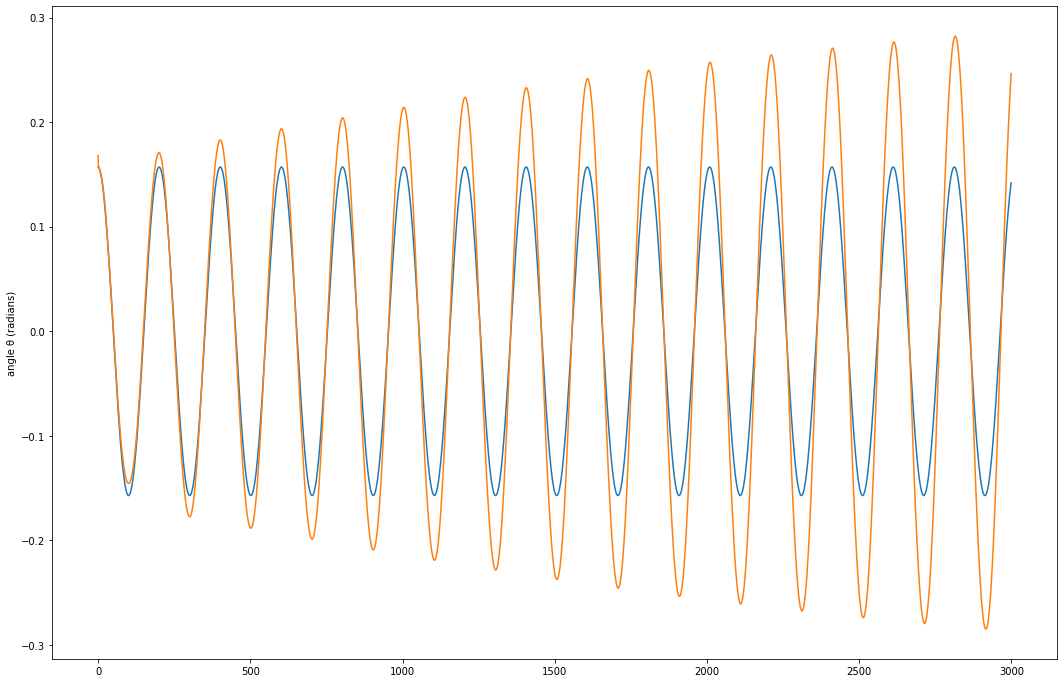

In [610]:

(e_aList, e_penLen, e_vxBias, e_alBias, e_avBias) = estimateGyro(inData, iAngle+iAngleError, pLen+pLenError, g)

fig, ax = plt.subplots(figsize=figSize)
ax.plot(angleList) # the real angle
ax.set_ylabel("angle θ (radians)")
#ax.plot(w)
ax.plot(e_aList) # the estimated angle, obviously drifting due to gyroBias (constant error in the angular velocity speed)

print('RMS Angle Estimation Error:', np.sqrt(np.sum((np.array(e_aList)-np.array(angleList))**2)))
print('Estimated Pendulum Length:',e_penLen,' Real Penndulum length:', pLen)
print('Estimated Radar bias:', e_vxBias,' Real Radar bias:', vxBias)
print(' Estimated AccL bias:', e_alBias,'  Real AccL bias:', alBias)
print(' Estimated AccV bias:', e_avBias,'  Real AccV bias:', avBias)
    